In [ ]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = ""

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mikkelbhnke/steam-reviews",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

In [2]:
%%capture
#!pip install tensorflow --upgrade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

import nltk
import string
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(
    "/kaggle/input/steam-reviews/steam.csv",
    names=["game_id", "content", "is_positive", "num_recommendations"],
    header=None
)

df.head()

,game_id,content,is_positive,num_recommendations
0,10,Ruined my life.,1,0
1,10,This will be more of a ''my experience with th...,1,1
2,10,This game saved my virginity.,1,0
3,10,• Do you like original games? • Do you like ga...,1,0
4,10,"Easy to learn, hard to master.",1,1


In [4]:
df.shape

(6417106, 4)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6417106 entries, 0 to 6417105
Data columns (total 4 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   game_id              int64 
 1   content              object
 2   is_positive          int64 
 3   num_recommendations  int64 
dtypes: int64(3), object(1)
memory usage: 195.8+ MB


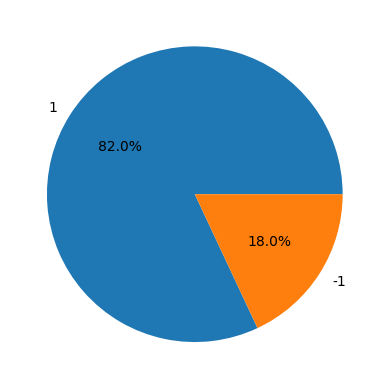

In [6]:
plt.pie(df['is_positive'].value_counts().values,
        labels = df['is_positive'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

In [7]:
filtered = df[df['is_positive'].isin([-1, 1])]

min_count = filtered['is_positive'].value_counts().min()

balanced_df = filtered.groupby('is_positive').sample(n=min_count, random_state=42).reset_index(drop=True)

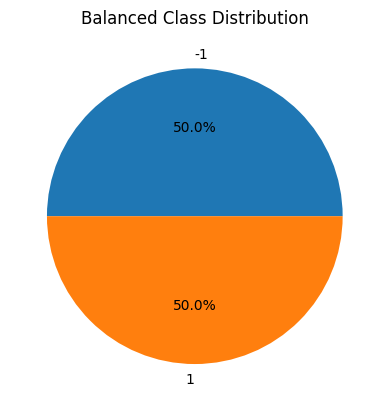

In [8]:
# Visualize the balanced distribution
plt.pie(balanced_df['is_positive'].value_counts().values,
        labels=balanced_df['is_positive'].value_counts().index,
        autopct='%1.1f%%')
plt.title("Balanced Class Distribution")
plt.show()

In [9]:
df['content'] = df['content'].fillna("").astype(str)
df['content'] = df['content'].str.lower()

punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

df['content'] = df['content'].apply(lambda x: remove_punctuations(x))
df.head()

,game_id,content,is_positive,num_recommendations
0,10,ruined my life,1,0
1,10,this will be more of a my experience with this...,1,1
2,10,this game saved my virginity,1,0
3,10,• do you like original games • do you like gam...,1,0
4,10,easy to learn hard to master,1,1


In [10]:
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words]
    return " ".join(words)

balanced_df['content'] = balanced_df['content'].fillna("").astype(str)
balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

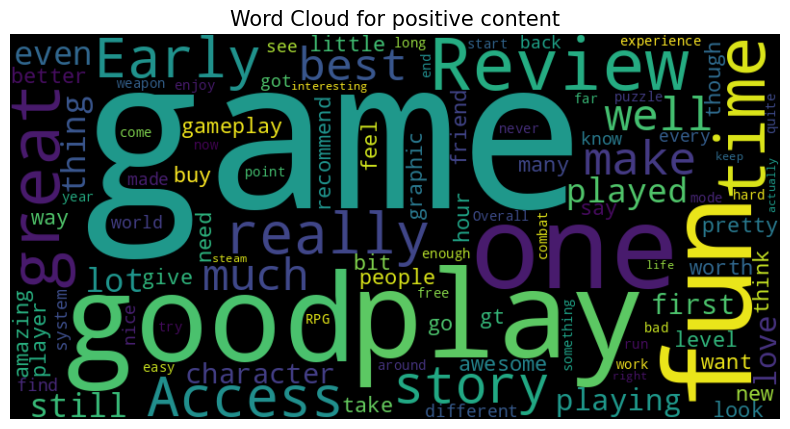

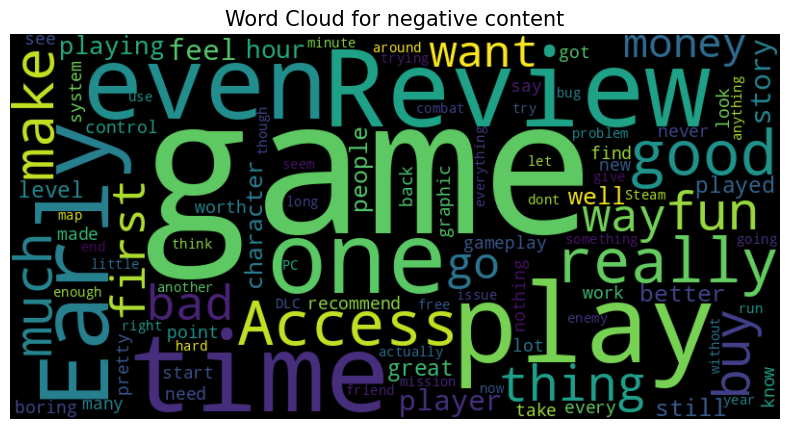

In [11]:
def plot_word_cloud(data, typ):
    # Limit to first 10,000 reviews to avoid MemoryError
    limited_data = data['content'].head(10000)
    corpus = " ".join(limited_data)
    wc = WordCloud(max_words=100, width=800, height=400, collocations=False).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {typ} content", fontsize=15)
    plt.show()

plot_word_cloud(balanced_df[balanced_df['is_positive'] == 1], "positive")
plot_word_cloud(balanced_df[balanced_df['is_positive'] == -1], "negative")

In [12]:
features = balanced_df['content']
target = balanced_df['is_positive']
X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=42)

# One-hot encode the labels
Y_train = pd.get_dummies(Y_train)
Y_val = pd.get_dummies(Y_val)

# Tokenization
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad sequences
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

max_words = 10000
max_len = 100 

model = keras.models.Sequential([
    layers.Embedding(input_dim=max_words, output_dim=32, input_length=max_len),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(256, activation='relu', kernel_regularizer='l1'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])

model.build(input_shape=(None, max_len))

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1758812077.943262      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 32)        │       320,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 354,818 (1.35 MB)

 Trainable params: 354,306 (1.35 MB)

 Non-trainable params: 512 (2.00 KB)

In [15]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = "best_model.keras"

mc = ModelCheckpoint(filepath=checkpoint_path,
                     monitor='val_accuracy',
                     save_best_only=True,
                     verbose=1)

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)

In [16]:
history = model.fit(X_train_padded, Y_train,
                    validation_data=(X_val_padded, Y_val),
                    epochs=50,
                    batch_size=128,
                    callbacks=[es, lr, mc])

Epoch 1/50


I0000 00:00:1758812101.365753     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


14458/14459 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7862 - loss: 0.6973
Epoch 1: val_accuracy improved from -inf to 0.81295, saving model to best_model.keras
14459/14459 ━━━━━━━━━━━━━━━━━━━━ 256s 17ms/step - accuracy: 0.7862 - loss: 0.6973 - val_accuracy: 0.8129 - val_loss: 0.4068 - learning_rate: 0.0010
Epoch 2/50
14459/14459 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8140 - loss: 0.4067
Epoch 2: val_accuracy improved from 0.81295 to 0.82034, saving model to best_model.keras
14459/14459 ━━━━━━━━━━━━━━━━━━━━ 248s 17ms/step - accuracy: 0.8140 - loss: 0.4067 - val_accuracy: 0.8203 - val_loss: 0.4004 - learning_rate: 0.0010
Epoch 3/50
14456/14459 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8201 - loss: 0.3956
Epoch 3: val_accuracy improved from 0.82034 to 0.82311, saving model to best_model.keras
14459/14459 ━━━━━━━━━━━━━━━━━━━━ 248s 17ms/step - accuracy: 0.8201 - loss: 0.3956 - val_accuracy: 0.8231 - val_loss: 0.3919 - learning_rate: 0.0010
Epoch 4/50
14459/14459 ━━━━━━━

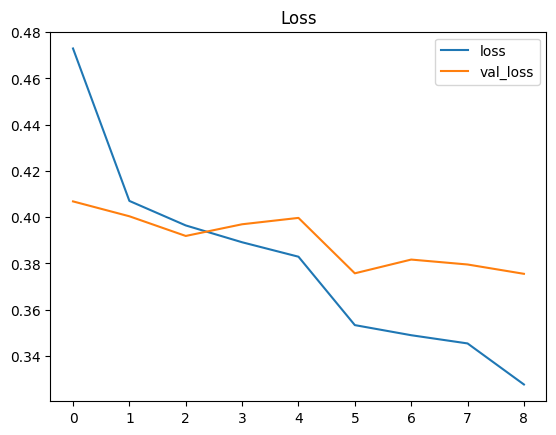

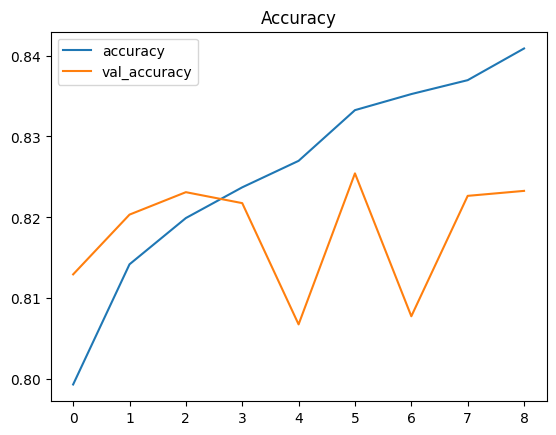

In [17]:
history_df = pd.DataFrame(history.history)

history_df[['loss', 'val_loss']].plot(title="Loss")

history_df[['accuracy', 'val_accuracy']].plot(title="Accuracy")
plt.show()

In [18]:
best_model = keras.models.load_model(checkpoint_path)

In [19]:
test_loss, test_acc = best_model.evaluate(X_val_padded, Y_val)
print(f"Test Accuracy: {test_acc:.2f}")

14459/14459 ━━━━━━━━━━━━━━━━━━━━ 94s 6ms/step - accuracy: 0.8258 - loss: 0.3747
Test Accuracy: 0.83


14459/14459 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step


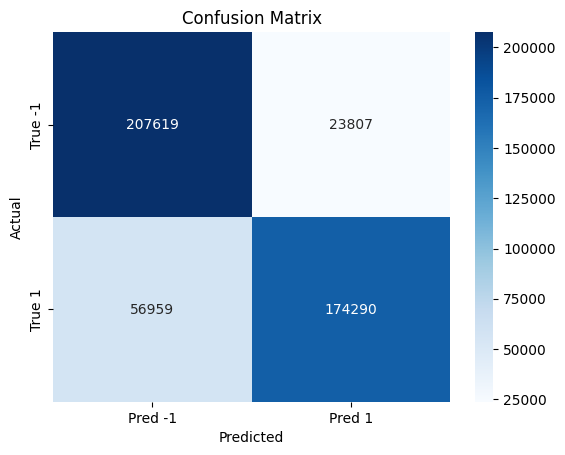

              precision    recall  f1-score   support

          -1      0.785     0.897     0.837    231426
           1      0.880     0.754     0.812    231249

    accuracy                          0.825    462675
   macro avg      0.832     0.825     0.825    462675
weighted avg      0.832     0.825     0.825    462675

Text: The game seems fun. I played I liked I came back play launch. Even reinstalling work. I find anything fix I'm pretty disappointed I bought this.
True label: -1 Predicted: -1
---
Text: Excellent game made skilled artist 3D modellors. The team manages engine physic quite good, though best. Aircraft vehicle modelleling greatest I've seen game variety vehicles. Gameplay amazingly smooth simple. I cannot recommend due many controversial decision made developers. Ignoring playerbase term balancing matchmaking. Gaijin created problem becomes worse. When many player playing large range vehicles, (generally) effective matchmaking would clump evenly matched vehicle tog

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model = keras.models.load_model(checkpoint_path)

# Predict probabilities
y_pred_probs = best_model.predict(X_val_padded)
y_pred_labels = y_pred_probs.argmax(axis=1)

# Map 0 → -1 and 1 → 1
y_pred_labels = np.where(y_pred_labels == 0, -1, 1)

# True labels
y_true_labels = Y_val.idxmax(axis=1).values

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=[-1, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred -1', 'Pred 1'],
            yticklabels=['True -1', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true_labels, y_pred_labels, digits=3))

# Show some example predictions with a random_state for reproducibility
# Random but reproducible positions
n = len(y_true_labels)
rng = np.random.default_rng(seed=42)
sampled_idx = rng.choice(n, size=5, replace=False)

# Show predictions
for i in sampled_idx:
    print("Text:", features.iloc[i])   # assumes features was split into val set
    print("True label:", y_true_labels[i], "Predicted:", y_pred_labels[i])
    print("---")